In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Tube: 
    
    def __init__(self, tag, sframe, eframe):
        self.tag = tag
        self.sframe = sframe 
        self.eframe = eframe 
        self.bbX = [] # bounding box x-axis 
        self.bbY = [] # bounding box y-axis
        self.bbH = [] # bounding box height
        self.bbW = [] # bounding box width
        
    def __len__(self):
        return len(self.bbX)
    
    def frame_length(self):
        return self.eframe - self.sframe
    
    def next_bounding_box(self, x, y, w, h):
        self.bbX.append(x)
        self.bbY.append(y)
        self.bbW.append(w)
        self.bbH.append(h)

    def get_bounding_box_at_frame(self, frame):
        i = frame - self.sframe
        return (self.bbX[i], self.bbY[i], self.bbW[i], self.bbH[i])
         
    def __iter__(self):
        self.iteridx = 0
        return self

    def __next__(self):
        if self.iteridx < len(self):
            frame = self.sframe + self.iteridx
            x, y, h, w = self.get_bounding_box_at_frame(frame)
            self.iteridx += 1
            return x, y, h, w, frame
        else:
            raise StopIteration
    
    def __str__(self):
        return self.tag
    
    def plot(self):
        plt.scatter(self.bbX, self.bbY, s=self.bbW, label=self.tag, marker='s')
        plt.plot(self.bbX, self.bbY, label='_nolegend_')
        

In [3]:
import pandas as pd
columns = [
    'frame', 
    'tag', 
    'x', 
    'y', 
    'w',
    'h',
]
with open('/Users/nguyenduy/Desktop/pcgvs-main/notebooks/data/test2.txt') as output:
    rawdata = [ line.strip().split(' ')[:6] for line in output.readlines() ]
    df = pd.DataFrame(rawdata, columns=columns)
    df = df.astype('int')

df.head(100)

,frame,tag,x,y,w,h
0,3,1,0,108,77,240
1,4,1,0,109,77,240
2,5,2,1868,63,51,145
3,6,2,1860,61,59,146
4,7,2,1860,62,59,146
...,...,...,...,...,...,...
95,460,8,1783,53,110,160
96,461,8,1783,54,110,160
97,462,8,1784,53,109,160
98,463,8,1784,53,109,160


In [4]:
tubes = []

for tag in df.tag.unique():
    ob_df = df[df['tag'] == tag]
    if (len(ob_df) < 10): continue # remove shadows
    ob_df = ob_df.sort_values(by='frame')
    sframe = ob_df.frame.min()
    eframe = ob_df.frame.max()
    tube = Tube(tag, sframe, eframe)
    tubes.append(tube)
    for _, r in ob_df.iterrows():
        tube.next_bounding_box(r['x'], r['y'], r['w'], r['h'])

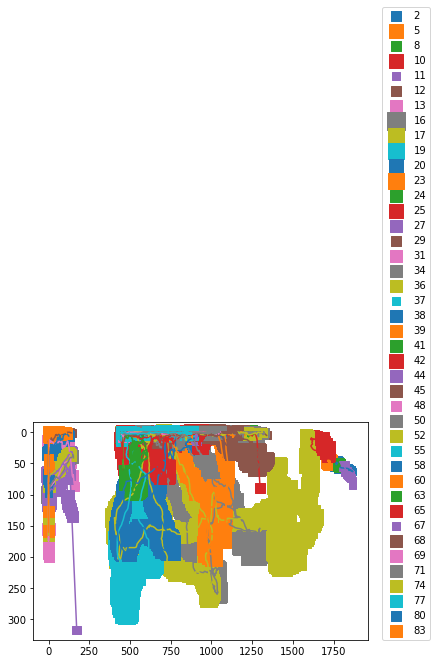

In [5]:
import matplotlib.pyplot as plt

def plot_tubes(tubes):
    plt.clf()
    for tube in tubes:
        tube.plot()
    plt.gca().invert_yaxis()
    plt.legend(loc=(1.04,0))
    plt.plot()
    
plot_tubes(tubes)

In [6]:
from itertools import permutations

class Overlapping:
    def __init__(self, start, end):
        self.sframe = start
        self.eframe = end
    def __str__(self):
        return 'OVL'

    
class Intersection:
    def __init__(self, frame):
        self.frame = frame
    def __str__(self):
        return 'INT'
    
    
class RelationsMap:
    def __init__(self, tubes):
        self.tubes = tubes
        self.relations = {}
        for Ta in tubes:
            self.relations[Ta.tag] = {}
            for Tb in tubes:
                self.relations[Ta.tag][Tb.tag] = None

    def compute(self):        
        for Ta, Tb in permutations(self.tubes, 2):
            if Ta == Tb: continue
            # we focus on tube A and check the
            # intersections with Tube B. 
            f_inter = None
            l_inter  = None
            for adata in Ta:
                for bdata in Tb:
                    frame = adata[4]
                    if self._frames_intersect(adata, bdata):
                        f_inter = frame if f_inter is None else f_inter
                        l_inter = frame
            # In this case, there isn't interaction.
            if l_inter is None: continue
            # Following the paper recommendations, we 
            # set the interaction as overlapping if there 
            # are more than 5 intersecting frames. 
            self.relations[Ta.tag][Tb.tag] = Intersection(f_inter) \
                if l_inter - f_inter < 5 \
                else Overlapping(f_inter, l_inter)
              
    def _frames_intersect(self, adata, bdata):
        xa, ya, wa, ha, fa = adata
        xb, yb, wb, hb, fb = bdata
        l_ax, l_ay = xa, ya # Top-left point of square A
        r_ax, r_ay = xa + wa, ya + ha # Bottom-right point of square A
        l_bx, l_by = xb, yb # Top-left point of square B
        r_bx, r_by = xb + wb, yb + hb # Bottom-right point of square B
        # Check if one square has empty area.
        if l_ax == r_ax or l_ay == r_ay or l_bx == r_bx or l_by == r_by:
            return False
        # Check if one square stands above the other.
        if r_ay < l_by or r_by < l_ay:
            return False
        # Check if one square stands on the left of the other
        if r_ax < l_bx or r_bx < l_ax:
            return False
        # The squares overlap!
        return True
    
    
    def as_dict(self):
        return self.relations
    
    
    def __str__(self):
        out = ""
        for k1 in self.relations.keys():
            out += f'[{k1}]:\t'
            for k2 in self.relations.keys():
                out += f'({k2}){self.relations[k1][k2]}\t'
            out += '\n'
        return out

In [7]:
rmap = RelationsMap(tubes)
rmap.compute()
print(rmap)

[2]:	(2)None	(5)OVL	(8)OVL	(10)OVL	(11)OVL	(12)None	(13)None	(16)OVL	(17)OVL	(19)None	(20)None	(23)None	(24)None	(25)None	(27)None	(29)None	(31)None	(34)None	(36)None	(37)None	(38)None	(39)None	(41)None	(42)None	(44)None	(45)None	(48)None	(50)None	(52)None	(55)None	(58)None	(60)None	(63)None	(65)None	(67)None	(68)None	(69)None	(71)None	(74)None	(77)None	(80)None	(83)None	
[5]:	(2)OVL	(5)None	(8)OVL	(10)OVL	(11)OVL	(12)None	(13)None	(16)OVL	(17)OVL	(19)None	(20)None	(23)None	(24)None	(25)None	(27)None	(29)None	(31)None	(34)None	(36)None	(37)None	(38)None	(39)None	(41)None	(42)None	(44)None	(45)None	(48)None	(50)None	(52)None	(55)None	(58)None	(60)None	(63)None	(65)None	(67)None	(68)None	(69)None	(71)None	(74)None	(77)None	(80)None	(83)None	
[8]:	(2)OVL	(5)OVL	(8)None	(10)OVL	(11)OVL	(12)None	(13)None	(16)OVL	(17)OVL	(19)None	(20)None	(23)None	(24)None	(25)None	(27)None	(29)None	(31)None	(34)None	(36)None	(37)None	(38)None	(39)None	(41)None	(42)None	(44)None	(45)None	(48)None	(50)None	(5

# Potential Collision Graph

Prende in input le relazioni e i tubes, e crea un Potential Collision Graph formato da:
- m-nodes: essenzialmente i tubes 
- s-nodes: nodi all'interno degli m-nodes che rappresentano le potenziali collisioni

In [15]:
class MainNode:
    def __init__(self, tube):
        self.tube = tube
        self.color = None

class SubNode: 
    def __init__(self, tube, frame):
        self.tube = tube
        self.color = None
        self.frame = frame

Costruzione del potential collision graph:

- Prendo in input i tubes e la mappa di relazioni
- Per ogni tube:
    - Se il tube ha relazioni irrilevanti con gli altri, reifico in isolated main node
    - Altrimenti controllo le relazioni con gli altri tubi:
        - Se ha una relazione di intersezione, creo un subnode
        - Se ha una relazione di sovrapposizione, creo due subnode



In [21]:
import numpy as np

class PCG:
    
    def __init__(self, tubes, relations):
        self.tubes = tubes
        self.relations = relations
        self.nodes = {}
        self.edges = {}
        self.A = {}
        self._build_graph()
        
    def uncolored_nodes(self):
        return [ k for k, v in self.nodes.items() if v.color is None ]
    
    def node(self, key):
        return self.nodes[key]
    
    def generated_by_intersection(self, key: str):
        return len(key.split('-')) == 2
    
    def generated_by_overlapping(self, key:str):
        return len(key.split('-')) == 3    
    
    def identify_quatern(self, key):
        """ Given a subnode generated by an overlapping, returns (vs, ve, vsp, vep)
            where:
            - vs is the node corresponding to the overlapping start in the tube of key
            - ve is the node corresponding to the overlapping end in the tube of key
            - vsp is the node corresponding to the overlapping start in the other tube
            - vep is the node corresponding to the overlapping end in the other tube
        """
        if self.generated_by_intersection(key): 
            raise Exception('cannot identify quatern on intersection generated subnodes.')
        
        fr, to, ex = key.split('-')
        vs  = f'{fr}-{to}-s'
        ve  = f'{fr}-{to}-e'
        vsp = f'{to}-{fr}-s'
        vep = f'{to}-{fr}-e'
        return vs, ve, vsp, vep

    def identify_opposite(self, key:str):
        """ Given a subnode generated by overlapping, returns the opposite node.
            If the node is the starting one, the method returns the ending one, and viceversa.
        """
        if self.generated_by_intersection(key): 
            raise Exception('cannot identify opposite on intersection generated subnodes.')
        
        ex = 'e' if key[-1] == 's' else 's' 
        
        return key[:-1] + ex
        
        
    
    def adjacents(self, key):
        if key not in self.nodes: return None
        return [ (k, v) for k, v in self.nodes.items() if self.A[key][k] != 0 ]
        
    
    def clean_colors(self):
        for v in self.nodes.values():
            v.color = None
    
    def _build_graph(self):
        
        edges_list = []
        rmap = self.relations.as_dict()
    
        def generates_isolated_main_node(tube, tube_relations):
            """ If the tube has irrilevant relations with all 
                other tubes, then it can be abstracted as an isolated
                main-node.
            """
            return all([ r is None for r in tube_relations.values() ])
            
        def subnode_id(ptag, ctag, endpoint=''):
            """ 
            """
            assert endpoint in ['s', 'e', '']
            return f'{ptag}-{ctag}-{endpoint}'
            
        def edge_exists(edge):
            """
            """
            for _edge in edges_list:
                if edge[0] == _edge[0] and edge[1] == _edge[1]:
                    return True
            return False
            
        for tube in self.tubes:
            # print(f'computing for tube {tube.tag}')
             
            tube_relations = rmap[tube.tag]
            if generates_isolated_main_node(tube, tube_relations):
                self.nodes[tube.tag] = MainNode(tube)
                continue
            
            # If we arrive here, then our tube collide with some other tube,
            # hence, we must build an s-node for each potential collision. 
            
            for tag, relation in tube_relations.items():
                if tag == tube.tag or relation is None: continue
                    
                if type(relation) is Overlapping:
                    
                    Vs = subnode_id(tube.tag, tag, 's')
                    Ve = subnode_id(tube.tag, tag, 'e')
                    
                    # print(Vs, Ve, tag, tube.tag)
                    
                    self.nodes[Vs] = SubNode(tube, relation.sframe)
                    self.nodes[Ve] = SubNode(tube, relation.eframe)
                    
                    # Insert the direct edge between the nodes 
                    weight = relation.eframe - relation.sframe
                    edges_list.append((Vs, Ve, weight))
                    
                    # Insert undirected edges with colliding tube
                    Us = subnode_id(tag, tube.tag, 's')
                    Ue = subnode_id(tag, tube.tag, 'e')
                    
                    edge_Vs_Us = (Vs, Us, -1)
                    edge_Us_Vs = (Us, Vs, -1)
                    edge_Ve_Ue = (Ve, Ue, -1)
                    edge_Ue_Ve = (Ue, Ve, -1)
                    
                    if not edge_exists(edge_Vs_Us): edges_list.append(edge_Vs_Us)
                    if not edge_exists(edge_Us_Vs): edges_list.append(edge_Us_Vs)
                    if not edge_exists(edge_Ve_Ue): edges_list.append(edge_Ve_Ue)
                    if not edge_exists(edge_Ue_Ve): edges_list.append(edge_Ue_Ve)
                    
                elif type(relation) is Intersection:
                    self.nodes[subnode_id(tube.tag, tag)] = SubNode(tube, relation.frame)
                    
                    # add an edge in both directions 
                    
                    v1id = subnode_id(tag, tube.tag)
                    v2id = subnode_id(tube.tag, tag)
                    edge1 = (v1id, v2id, 1)
                    edge2 = (v2id, v1id, 1)
                                        
                    if edge1 not in edges_list:
                        edges_list.append(edge1)
                    if edge2 not in edges_list:
                        edges_list.append(edge2)
            
        self.edges = edges_list
        
        for v in self.nodes:
            self.A[v] = {}
            for u in self.nodes:
                self.A[v][u] = 0
        
        for v, u, w in edges_list:
            self.A[v][u] = w

In [22]:
from pcgvs.aggregation.graph import PCG
from pcgvs.aggregation.coloring import color_graph
pcg = PCG(tubes, relations)
color_graph(pcg, q)


KeyError: '38-29-s'

In [18]:
import pandas as pd

with open('data/adjacency_matrix.txt', 'w') as tmp:
    df = pd.DataFrame.from_dict(pcg.A)
    tmp.write(df.to_string())

FileNotFoundError: [Errno 2] No such file or directory: 'data/adjacency_matrix.txt'

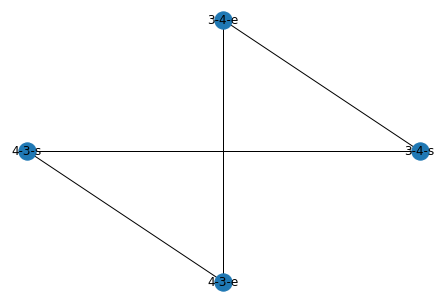

In [11]:
import networkx as nx

G = nx.from_edgelist([( u, v, {'weight': w}) for u, v, w in pcg.edges ])
nx.draw_circular(G, with_labels = True)

# Graph coloring


In [12]:
class SaturationCache:
    
    def __init__(self, pcg):
        self.pcg = pcg
        self.Sl   = {}
        self.Sapp = {}
        self.Spc  = {}
        self._init_params()
    
    def _init_params(self):
        """ Precalculate some parameters used in the metrics. 
        """
        tubes = self.pcg.tubes
        self.video_frames = max([ tube.eframe for tube in tubes ])
        self.max_length_tube = max([ tube.frame_length() for tube in tubes ])
          
    
    def _Sl(self, nodekey):
        """ Mesure the relative length (in terms of frames) of the
            tube corresponding to the node referenced by nodekey. The
            mesure is normalized using the tube with maximum length. 
        """
        if nodekey in self.Sl: return self.Sl[nodekey]
        tube  = self.pcg.nodes[nodekey].tube
        self.Sl[nodekey] = tube.frame_length() / self.max_length_tube
        return self.Sl[nodekey]
    
    
    def _Sapp(self, nodekey):
        """ Mesure the relative time of appearance of the tube 
            corresponding to the node referenced by nodekey.
        """
        if nodekey in self.Sapp: return self.Sapp[nodekey]
        tube  = self.pcg.nodes[nodekey].tube
        self.Sapp[nodekey] = (self.video_frames - tube.sframe) / self.video_frames
        return self.Sapp[nodekey]
    
    
    def _Spc(self, nodekey):
        """ <Not sure this is correct, check out the paper>
        """
        if nodekey in self.Spc: return self.Spc[nodekey]
        tubes = pcg.tubes
        tube  = pcg.nodes[nodekey].tube
        same_mnode = len([ node for node in pcg.nodes.values() if node.tube.tag == tube.tag ])
        self.Spc[nodekey] =  same_mnode / len(pcg.nodes)
        return self.Spc[nodekey]
    
    
    def _Sd(self, nodekey):
        """ Classic saturation, but normalized. Counts the number
            of different colors in the adjacents nodes of the node
            referenced by nodekey. This one cannot be cached. 
        """
        #colorset = set()
        # ERRORE
        nodes_weight_map = pcg.A[nodekey]
        adjacent_nodes = [ v for v, w in nodes_weight_map.items() if w != 0 ]
        sat = len([ k for k in adjacent_nodes if pcg.nodes[k].color is not None ])
        return sat / len(pcg.nodes)
    
    
    def saturation(self, nodekey):
        """ Calculate the saturation of the node.
        """
        return self._Sd(nodekey) \
             + self._Sl(nodekey) \
             + self._Sapp(nodekey) \
             + self._Spc(nodekey)
    
    def saturations(self, nodekeys):
        """ Calculate the saturation of all the nodes. 
        """
        return { k:self.saturation(k) for k in nodekeys }
    

Empiricamente si ha un buon parametro $q$ per $q=3$ nel caso di macchine

Definiamo le condizioni per la colorazione:

In [13]:
import numpy as np

def q_far_apart(pcg, proposed_color, nodekey, q=5):
    """ This condition imposes that all the nodes connected by an
        edge weighted 1 (intersection) to the node referenced by node-key, 
        must be at least q color far apart. 
    """
    adjacents = pcg.adjacents(nodekey)
    for key, node in adjacents:
        if pcg.A[nodekey][key] != 1: continue 
        if node.color is None: continue
        if np.abs(node.color - proposed_color) <= q:
            return False
    return True


def does_not_overlap(pcg: PCG, proposed_color, nodekey):
    """ See condition 2 in paper He et Al. 
    """
    if pcg.generated_by_intersection(nodekey): return True
    vi, vj, vip, vjp = pcg.identify_quatern(nodekey)
    vi, vj, vip, vjp = pcg.node(vi), pcg.node(vj), pcg.node(vip), pcg.node(vjp)
    if vip.color is None or vjp.color is None: return True
    tij = vj.frame - vi.frame
    return (proposed_color - vip.color) * (proposed_color + tij - vjp.color) > 0
    
#q_far_apart(pcg, 1, '10-2-s')
#does_not_overlap(pcg, 1, '6-2-s')

Algoritmo di sorting sulla base della saturazione, che risolve i pareggi in base al tempo di apparizione, come descritto nel paper.

In [14]:
def ssort(saturations, pcg):
    """
    """
    olist = []
    nnodes = len(saturations)
    while len(olist) < nnodes:
        max_sat = max(saturations.values())
        ties = [ nk for nk in saturations.keys() if saturations[nk] == max_sat ]
        appearings = { nk:pcg.nodes[nk].tube.sframe for nk in ties }
        winner_key = min( appearings.items(), key=operator.itemgetter(1) )[0]
        olist.append(winner_key)
        del saturations[winner_key]
    return olist

Procediamo con l'algoritmo

In [15]:
import operator


def color_graph(pcg: PCG, q=5):
    """
    """
    color = 1
    pcg.clean_colors()
    sc = SaturationCache(pcg)    
    
    while len(pcg.uncolored_nodes()) > 0:
        nodes_not_colored = pcg.uncolored_nodes()
        saturations = sc.saturations(nodes_not_colored)
        ordered_list = ssort(saturations, pcg)
        saturations = sc.saturations(nodes_not_colored)
        
        for nodekey in ordered_list:
            if pcg.node(nodekey).color is not None: continue
            if q_far_apart(pcg, color, nodekey, q) and does_not_overlap(pcg, color, nodekey):
                
                pcg.nodes[nodekey].color = color
                if pcg.generated_by_overlapping(nodekey):
                    oppnode = pcg.node(pcg.identify_opposite(nodekey))
                    if oppnode.color is not None: continue
                    m = 1 if nodekey[-1] == 's' else -1
                    vs, ve, _, _ = pcg.identify_quatern(nodekey)
                    delta = pcg.node(ve).frame - pcg.node(vs).frame
                    oppnode.color = color + m * delta  

        color += 1
        

In [16]:
color_graph(pcg, q=3)

[ (nk, node.color) for nk, node in pcg.nodes.items()  ]

[('3-4-s', 1), ('3-4-e', 13), ('4-3-s', 4), ('4-3-e', 14)]

# Condensation Optimization

Proposed in Allegra et Al.

Step n.1:

In [17]:
li = {}

def starting_nodes_or_intersections(pcg, tube):
    selected_nodes = []
    for key, node in pcg.nodes.items():
        if node.tube.tag != tube.tag or key[-1] == 'e': continue
        selected_nodes.append((key, node))
    return selected_nodes

for tube in tubes:
    nodes = starting_nodes_or_intersections(pcg, tube)
    optim = lambda node: node.color - (node.frame - tube.sframe)    
    li[tube.tag] = max(1, min([ optim(node) for _, node in nodes ]))    

Step n.2:

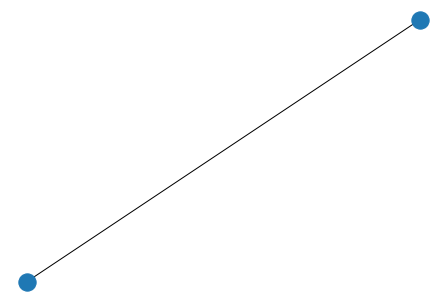

In [18]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([ tube.tag for tube in tubes ])

edges = set()

for k1, v1 in pcg.nodes.items():
    for k2, v2 in pcg.nodes.items():
        if pcg.A[k1][k2] == 0 or v1.tube.tag == v2.tube.tag: continue
        edges.add(( v1.tube.tag, v2.tube.tag ))
        
G.add_edges_from(list(edges))
            
nx.draw_circular(G)

In [19]:
q=3
starting_time = {}

def get_ordered_dict(_dict, keys_vocab):
    return { k: v for k, v in sorted(_dict.items(), key=lambda item: item[1]) if k in keys_vocab}

for Ck in nx.connected_components(G):
    Ck_ordered = get_ordered_dict(li, Ck).keys()    
    l1 = min([ l for tag, l in li.items() if tag in Ck ])
    for i, tag in enumerate(Ck_ordered):
        starting_time[tag] = l1 + (q * i)
        
starting_time

{3: 1, 4: 4}

# Video Synopsis Generation

In [20]:
with open('data/video-2-raw.txt') as output:
    rawdata = [ line.strip().split(' ')[:6] for line in output.readlines() ]
    df = pd.DataFrame(rawdata, columns=columns)
    df = df.astype('int')

df.head(10)

,frame,tag,x,y,w,h
0,143,3,146,342,344,140
1,144,3,192,327,339,152
2,145,3,233,338,343,145
3,146,3,273,341,359,144
4,147,3,319,341,344,142
5,148,3,362,341,336,141
6,149,3,401,340,339,143
7,150,3,444,340,349,142
8,151,3,488,341,338,142
9,152,3,528,341,340,141


In [21]:
new_frames = []

sframes = {}
for tube in tubes:
    sframes[tube.tag] = tube.sframe
    
for idx, row in df.iterrows():
    if row['tag'] not in sframes: continue
    new_frame_start = row['frame'] - sframes[row['tag']] + starting_time[row['tag']]
    new_frames.append(new_frame_start)

Add the new frames to the dataframe

In [22]:
# remove non-existing objects
df = df.loc[df['tag'].isin(sframes.keys())]

# insert new frames
df = df.assign(newframe=new_frames)

df.tail()

,frame,tag,x,y,w,h,newframe
61,403,4,664,69,55,54,40
62,404,4,664,66,54,52,41
63,405,4,664,63,53,49,42
64,406,4,665,58,50,52,43
65,407,4,664,54,50,53,44


In [23]:
df.to_csv('data/video-2-synopsis.csv', index=False)